# Design Validation Plates

We want to design 4 plates for experimental validation

## exp100 / "cherry-picking plate"
One plate containing 320 compounds.
Design Process:
1. Select 15 representative Initiators, 15 representative Monomers and 10 representative Terminators
2. Filter out any known combinations
3. Let the model predict reaction outcome and remove all combinations where the predicted reaction outcome is negative
4. Randomly select 320 of the remaining compounds
5. Design source plate and transfer files for this plate

## exp101 / "extrapolation plates"
Three plates of 320 compounds each for a total of 960 compounds
12 I x 10 M x 8 T
We have identified 12 previously unused Initiators
Design process:
1. Select 10 representative Monomers and 8 representative Terminators 
    (here we can just use the first 10, resp. 8) sampled for the other experiment as sampling is done before prediction and thus unbiased.
2. We will use a full factorial design and only need to design the appropriate source plate and transfer files


In [101]:
import pathlib
import sys
from collections import Counter
import csv

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw,rdMolDescriptors,AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import SimDivFilters,DataStructs

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection
from src.util.rdkit_util import desalt_building_block

In [76]:
con = SynFermDatabaseConnection()

In [77]:
res = con.con.execute("SELECT * FROM building_blocks").fetchall()
header = [i[1] for i in con.con.execute("PRAGMA table_info(building_blocks)").fetchall()]
df = pd.DataFrame(res, columns=header)
initiators = df.loc[df["category"] == "I"]
monomers = df.loc[df["category"] == "M"]
terminators = df.loc[df["category"] == "T"]

## Idea 1: RDKit's MinMaxPicker

In [36]:
mols = [Chem.MolFromSmiles(smi) for smi in terminators["SMILES"]]

fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2) for m in mols]

In [42]:
# https://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
def dmat_sim(fps,ntopick):
    ds=[]
    for i in range(1,len(fps)):
         ds.extend(DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i],returnDistance=True))
    mmp =SimDivFilters.MaxMinPicker()
    ids=mmp.Pick(np.array(ds),len(fps),ntopick)
    return ids

dmat_ids=dmat_sim(fps, 10)

Draw.MolsToGridImage([mols[x] for x in dmat_ids],molsPerRow=5, subImgSize=(300,300))

### Idea 1 conclusion
Due to how the MinMaxPicker works we sample the "weirdest" compounds, the ones most disparate from each other and thus our data set. This does not make sense when we want representative compounds

## Idea 2: Random picking


In [78]:
# still need to filter to only have the ones that were not excluded during data analysis
experiments = con.get_experiments_table_as_df()

In [79]:
valid_exp = experiments.loc[(~experiments["valid"].str.contains("ERROR", na=False)) & (experiments["exp_nr"].between(4,29))]
valid_ini = set(valid_exp["initiator_long"].to_numpy().tolist())
valid_mon = set(valid_exp["monomer_long"].to_numpy().tolist())
valid_ter = set(valid_exp["terminator_long"].to_numpy().tolist())

len(valid_ini), len(valid_mon), len(valid_ter)

(67, 72, 41)

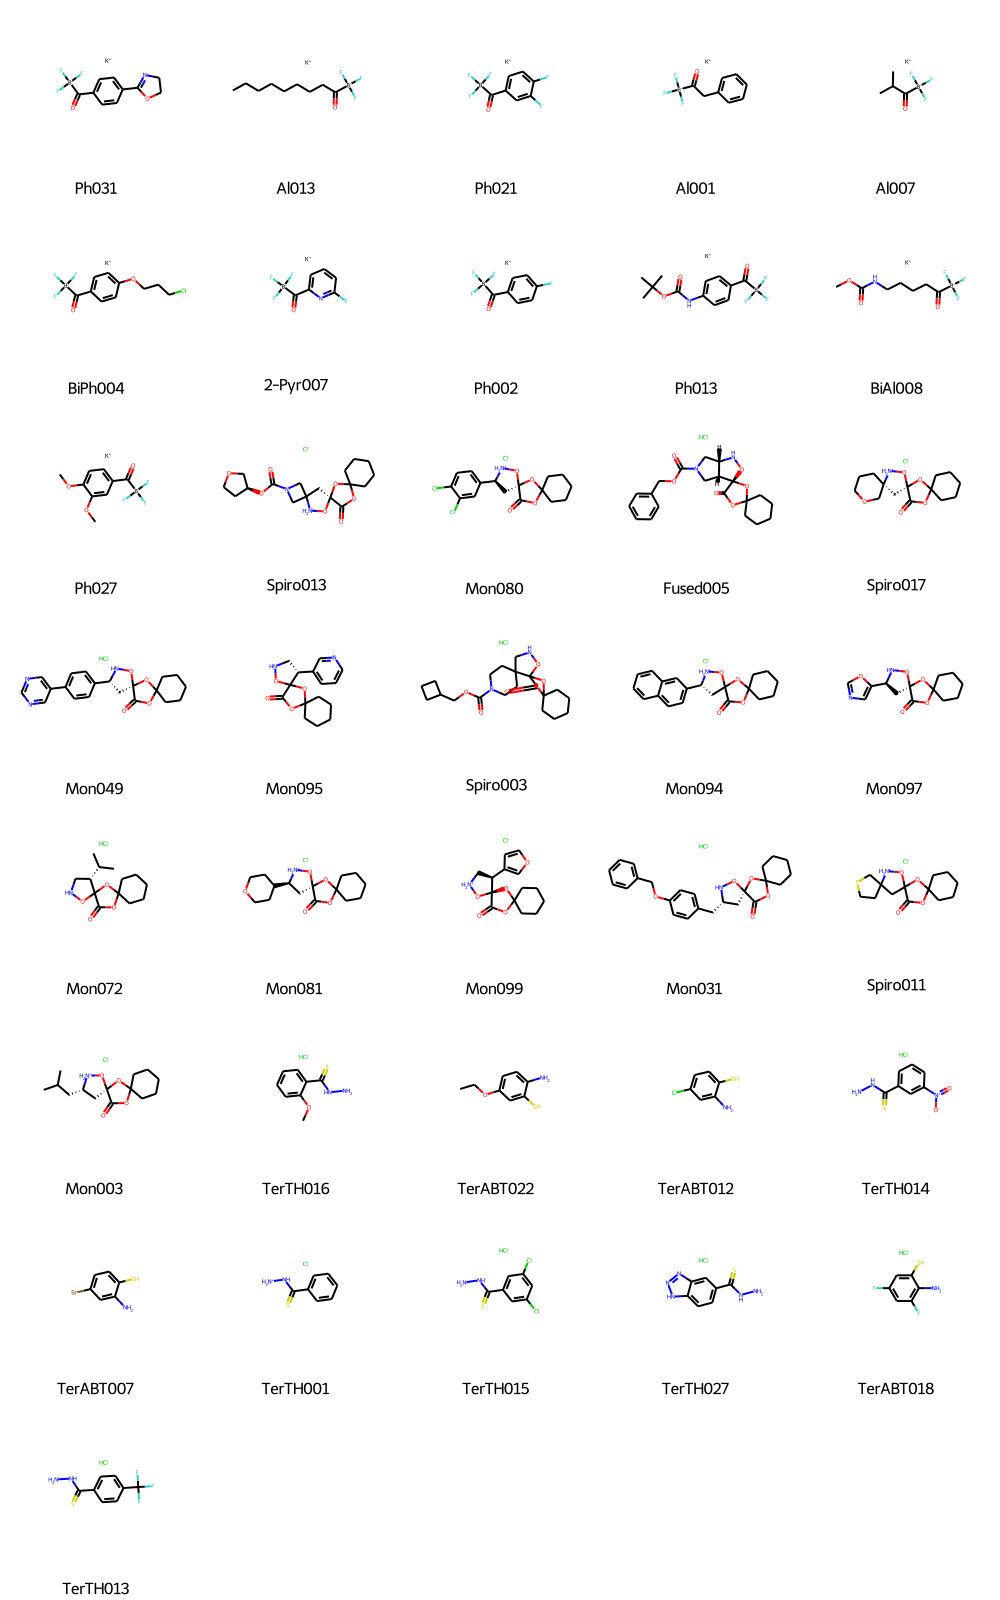

In [80]:
# draw randomly
select_ini = initiators.loc[initiators["long"].isin(valid_ini)].sample(11, random_state=1)
select_mon = monomers.loc[monomers["long"].isin(valid_mon)].sample(15, random_state=2)
select_ter = terminators.loc[terminators["long"].isin(valid_ter)].sample(10, random_state=3)

selected = pd.concat((select_ini, select_mon, select_ter))

Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in selected["SMILES"]], legends=selected["long"].to_numpy().tolist(), molsPerRow=5)


In [9]:
# do not use 4-Pyrazole002, BiPh009, Mon082. These are the building blocks we had to remove in data curation.

In [10]:
# from these, we remove all combinations where we attempted synthesis
products = [f"{i} + {j} + {k}" for i in select_ini["long"] for j in select_mon["long"] for k in select_ter["long"]]
len(products)

1650

In [11]:
attempted = experiments.loc[experiments["exp_nr"].between(4,29), "long_name"].to_numpy().tolist()
not_attempted = [p for p in products if p not in attempted]
len(not_attempted)

1192

In [15]:
not_attempted

['Ph031 + Spiro013 + TerTH016',
 'Ph031 + Spiro013 + TerABT022',
 'Ph031 + Spiro013 + TerABT012',
 'Ph031 + Spiro013 + TerTH015',
 'Ph031 + Spiro013 + TerTH027',
 'Ph031 + Spiro013 + TerABT018',
 'Ph031 + Spiro013 + TerTH013',
 'Ph031 + Mon080 + TerTH016',
 'Ph031 + Mon080 + TerABT022',
 'Ph031 + Mon080 + TerABT012',
 'Ph031 + Mon080 + TerTH014',
 'Ph031 + Mon080 + TerABT007',
 'Ph031 + Mon080 + TerTH001',
 'Ph031 + Mon080 + TerTH015',
 'Ph031 + Mon080 + TerTH027',
 'Ph031 + Mon080 + TerABT018',
 'Ph031 + Mon080 + TerTH013',
 'Ph031 + Fused005 + TerTH016',
 'Ph031 + Fused005 + TerABT022',
 'Ph031 + Fused005 + TerABT012',
 'Ph031 + Fused005 + TerTH015',
 'Ph031 + Fused005 + TerTH027',
 'Ph031 + Fused005 + TerABT018',
 'Ph031 + Fused005 + TerTH013',
 'Ph031 + Spiro017 + TerABT022',
 'Ph031 + Spiro017 + TerABT012',
 'Ph031 + Spiro017 + TerTH014',
 'Ph031 + Spiro017 + TerABT007',
 'Ph031 + Spiro017 + TerTH001',
 'Ph031 + Spiro017 + TerTH015',
 'Ph031 + Spiro017 + TerABT018',
 'Ph031 + Mon0

In [12]:
# for all the not attempted ones, write a file with the following columns:
# idx, vl_id, long_name, reaction_SMILES_atom_mapped
vl_ids, smiles = [], []
for long in not_attempted:
    res = con.con.execute("SELECT id, SMILES FROM virtuallibrary WHERE long_name IN (?) AND type = 'A';", (long,)).fetchall()
    assert len(res) == 1
    vl_ids.append(res[0][0])
    smiles.append(res[0][1])

In [16]:
df = pd.DataFrame({"vl_id": vl_ids, "long_name": not_attempted, "product_A_smiles": smiles})
df

,vl_id,long_name,product_A_smiles
0,224342,Ph031 + Spiro013 + TerTH016,COc1ccccc1-c1nnc(CC2(NC(=O)c3ccc(C4=NCCO4)cc3)...
1,224328,Ph031 + Spiro013 + TerABT022,CCOc1ccc2nc(CC3(NC(=O)c4ccc(C5=NCCO5)cc4)CN(C(...
2,224321,Ph031 + Spiro013 + TerABT012,O=C(NC1(Cc2nc3cc(Cl)ccc3s2)CN(C(=O)O[C@H]2CCOC...
3,224341,Ph031 + Spiro013 + TerTH015,O=C(NC1(Cc2nnc(-c3cc(Cl)cc(Cl)c3)s2)CN(C(=O)O[...
4,224351,Ph031 + Spiro013 + TerTH027,O=C(NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)CN(C(=O)O[...
...,...,...,...
1187,212800,Ph027 + Mon003 + TerABT012,COc1ccc(C(=O)N[C@H](Cc2nc3cc(Cl)ccc3s2)CC(C)C)...
1188,212820,Ph027 + Mon003 + TerTH015,COc1ccc(C(=O)N[C@H](Cc2nnc(-c3cc(Cl)cc(Cl)c3)s...
1189,212830,Ph027 + Mon003 + TerTH027,COc1ccc(C(=O)N[C@H](Cc2nnc(-c3ccc4[nH]nnc4c3)s...
1190,212806,Ph027 + Mon003 + TerABT018,COc1ccc(C(=O)N[C@H](Cc2nc3c(F)cc(F)cc3s2)CC(C)...


In [17]:
df.to_csv("../../data/curated_data/validation-plate_candidates.csv", index=False)

(at this point, predictions where run on a different machine in notebook `inference_validation-plate.ipynb`)

In [4]:
# load predictions
preds = pd.read_csv("../../data/curated_data/validation-plate_candidates_predictions.csv")
preds

,vl_id,long_name,product_A_smiles,reaction_smiles_atom_mapped,prob_A,prob_B,prob_C,pred_A,pred_B,pred_C
0,224342,Ph031 + Spiro013 + TerTH016,COc1ccccc1-c1nnc(CC2(NC(=O)c3ccc(C4=NCCO4)cc3)...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999996,0.999853,0.795703,1,1,1
1,224328,Ph031 + Spiro013 + TerABT022,CCOc1ccc2nc(CC3(NC(=O)c4ccc(C5=NCCO5)cc4)CN(C(...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.976899,0.043333,0.002816,1,0,0
2,224321,Ph031 + Spiro013 + TerABT012,O=C(NC1(Cc2nc3cc(Cl)ccc3s2)CN(C(=O)O[C@H]2CCOC...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.537250,0.051775,0.001379,0,0,0
3,224341,Ph031 + Spiro013 + TerTH015,O=C(NC1(Cc2nnc(-c3cc(Cl)cc(Cl)c3)s2)CN(C(=O)O[...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999267,0.999506,0.103978,1,1,0
4,224351,Ph031 + Spiro013 + TerTH027,O=C(NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)CN(C(=O)O[...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999868,0.999875,0.359415,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1187,212800,Ph027 + Mon003 + TerABT012,COc1ccc(C(=O)N[C@H](Cc2nc3cc(Cl)ccc3s2)CC(C)C)...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.835924,0.007893,0.032616,1,0,0
1188,212820,Ph027 + Mon003 + TerTH015,COc1ccc(C(=O)N[C@H](Cc2nnc(-c3cc(Cl)cc(Cl)c3)s...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.998910,0.945992,0.037713,1,1,0
1189,212830,Ph027 + Mon003 + TerTH027,COc1ccc(C(=O)N[C@H](Cc2nnc(-c3ccc4[nH]nnc4c3)s...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999806,0.964980,0.242855,1,1,0
1190,212806,Ph027 + Mon003 + TerABT018,COc1ccc(C(=O)N[C@H](Cc2nc3c(F)cc(F)cc3s2)CC(C)...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.958438,0.476284,0.008007,1,1,0


When preparing for the experiment, it turned out that our stock of Spiro003 is depleted. We remove this building block.

In [5]:
# how many possible experiments will be removed?
len(preds.loc[preds["long_name"].str.contains("Spiro003")])

94

In [6]:
# randomly sample 320 of the positive predictions to synthesize
sample = preds.loc[(preds["pred_A"] == 1) & (~preds["long_name"].str.contains("Spiro003"))].sample(320, random_state=42)
sample

,vl_id,long_name,product_A_smiles,reaction_smiles_atom_mapped,prob_A,prob_B,prob_C,pred_A,pred_B,pred_C
869,179066,Ph013 + Fused005 + TerTH001,CC(C)(C)OC(=O)Nc1ccc(C(=O)N[C@H]2CN(C(=O)OCc3c...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999598,0.997483,0.705942,1,1,1
235,91449,Al013 + Mon003 + TerTH001,CCCCCCCCC(=O)N[C@H](Cc1nnc(-c2ccccc2)s1)CC(C)C,F[B-](F)(F)[C:1](=[O:2])[CH2:11][CH2:12][CH2:1...,0.998999,0.999878,0.998489,1,1,1
81,223015,Ph031 + Mon081 + TerABT018,O=C(N[C@@H](Cc1nc2c(F)cc(F)cc2s1)C1CCOCC1)c1cc...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.987364,0.972276,0.007334,1,1,0
228,93807,Al013 + Spiro011 + TerTH027,CCCCCCCCC(=O)NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)C...,F[B-](F)(F)[C:1](=[O:2])[CH2:11][CH2:12][CH2:1...,0.837312,0.858687,0.998113,1,1,1
384,74343,Al001 + Mon081 + TerABT012,O=C(Cc1ccccc1)N[C@@H](Cc1nc2cc(Cl)ccc2s1)C1CCOCC1,F[B-](F)(F)[C:1](=[O:2])[CH2:15][c:16]1[cH:17]...,0.997867,0.152672,0.106093,1,0,0
...,...,...,...,...,...,...,...,...,...,...
783,157828,Ph002 + Fused005 + TerTH001,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(-c2...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999981,0.999997,0.930623,1,1,1
747,14298,2-Pyr007 + Mon099 + TerTH015,O=C(NC[C@@H](c1ccoc1)c1nnc(-c2cc(Cl)cc(Cl)c2)s...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.817030,0.953332,0.000505,1,1,0
793,158967,Ph002 + Mon049 + TerABT012,O=C(N[C@H](Cc1nc2cc(Cl)ccc2s1)c1ccc(-c2cncnc2)...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.999947,0.258035,0.020875,1,0,0
12,222977,Ph031 + Mon080 + TerTH001,O=C(N[C@@H](Cc1nnc(-c2ccccc2)s1)c1ccc(Cl)c(Cl)...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999972,0.999988,0.022515,1,1,0


In [7]:
building_blocks = sample["long_name"].str.split("+", expand=True).applymap(lambda x: x.strip())
building_blocks[0].drop_duplicates().sort_values()

653     2-Pyr007
384        Al001
475        Al007
235        Al013
962      BiAl008
599      BiPh004
794        Ph002
869        Ph013
294        Ph021
1163       Ph027
81         Ph031
Name: 0, dtype: object

In [8]:
building_blocks[1].drop_duplicates().sort_values()

869     Fused005
235       Mon003
922       Mon031
35        Mon049
294       Mon072
958       Mon080
81        Mon081
475       Mon094
458       Mon095
1021      Mon097
1163      Mon099
228     Spiro011
536     Spiro013
971     Spiro017
Name: 1, dtype: object

In [9]:
building_blocks[2].drop_duplicates().sort_values()

485     TerABT007
384     TerABT012
81      TerABT018
1163    TerABT022
869      TerTH001
1021     TerTH013
475      TerTH014
52       TerTH015
962      TerTH016
228      TerTH027
Name: 2, dtype: object

In [23]:
# design the source plate
from labware.plates import Plate384, Plate384Echo

In [18]:
source_plate = Plate384(max_vol=65000, dead_vol=15000)

In [19]:
# add initiators to source plate
for name, count in building_blocks[0].value_counts().items():
    source_plate.fill_well(source_plate.free(), name, count*990+15000)

# add monomers to source plate, starting at row F
for name, count in building_blocks[1].value_counts().items():
    source_plate.fill_well(source_plate.free(from_well="F1"), name, count*990+15000)

# add terminators to source plate, starting at row K
for name, count in building_blocks[2].value_counts().items():
    source_plate.fill_well(source_plate.free(from_well="K1"), name, count*1100+15000)
    
# add oxalic acid. For 320 reactions, we need two source wells, but we just fill up the entire bottom row for redundancy
for _ in range(24):
    source_plate.fill_well(source_plate.free(from_well="P1"), "X", 65000)

In [21]:
print(source_plate)

  1                               2                               3                               4                               5                               6                               7                               8                               9                               10                              11                              12                              13                              14                              15                              16                              17                              18                              19                              20                              21                              22                              23                              24                              
A (['Ph031'], 56580)              (['Al007'], 52620)              (['2-Pyr007'], 50640)           (['Al013'], 45690)              (['Ph027'], 44700)              (['BiAl008'], 42720)            (['BiPh004'], 42720)            (['

In [22]:
source_plate.to_csv("../../data/plates/exp100/source_plate_layout.csv", save_volumes=True)

In [43]:
# now make the target plate
target_plate = Plate384Echo()
# add placeholders
target_plate.fill_span("A1", "P2", "placeholder", target_plate.max_vol)
target_plate.fill_span("A23", "P24", "placeholder", target_plate.max_vol)
# add sampled reactions
for i, row in sample.iterrows():
    well = target_plate.free()
    compounds = row["long_name"].split(" + ")
    target_plate.fill_well(well, compounds[0], 990)
    target_plate.fill_well(well, compounds[1], 990)
    target_plate.fill_well(well, compounds[2], 1100)
    target_plate.fill_well(well, "X", 220)
# remove placeholders
target_plate.empty_span("A1", "P2")
target_plate.empty_span("A23", "P24")

In [44]:
print(target_plate)

  1                               2                               3                               4                               5                               6                               7                               8                               9                               10                              11                              12                              13                              14                              15                              16                              17                              18                              19                              20                              21                              22                              23                              24                              
A ([], 0)                         ([], 0)                         (['Ph013', 'Fused005', 'TerTH001', 'X'], 3300) (['Al013', 'Mon003', 'TerTH001', 'X'], 3300) (['Ph031', 'Mon081', 'TerABT018', 'X'], 3300) (['Al013', 'Spiro011', 'T

In [45]:
target_plate.to_csv("../../data/plates/exp100/plate_layout_plate1.csv", save_volumes=True)

In [56]:
compound_location = {compound[0]: well for well, compound in source_plate.to_dict().items() if len(compound) == 1}

In [57]:
# to prepare the tranfer files, just iterate the target plate
header = ['Source Barcode', 'Source Well', 'Destination Barcode', 'Destination Well', 'Volume']
step1_transfers, step2_transfers = [], []
step1_transfers.insert(0, header)
step2_transfers.insert(0, header)
source_barcode = 'Source1'
destination_barcode = 'Synthesis1'
for dest_well, compounds, volume in target_plate.iterate_wells():
    if volume == 0:
        continue  # skip empty wells
    step1_transfers.append([source_barcode, compound_location[compounds[0]], destination_barcode, dest_well, 990])
    step1_transfers.append([source_barcode, compound_location[compounds[1]], destination_barcode, dest_well, 990])
    step2_transfers.append([source_barcode, compound_location[compounds[2]], destination_barcode, dest_well, 1100])

    # add oxalic acid
    if int(dest_well[1:]) < 13:
        step1_transfers.append([source_barcode, "P1", destination_barcode, dest_well, 220])
    else:
        step1_transfers.append([source_barcode, "P2", destination_barcode, dest_well, 220])

In [65]:
# correct number of transfers?
assert len(step1_transfers) == 320 * 3 + 1
# source wells occur no more than 50 times (volume limit)?
used_wells = [l[1] for l in step1_transfers[1:]]
for k, v in Counter(used_wells).items():
    if k.startswith("A") or k.startswith("F"):
        assert v <= 50
    elif k.startswith("P"):
        assert v == 160
    else:
        raise ValueError(f"unexpected well {k}")
# all transfers are unique
assert len(step1_transfers) == len(set([tuple(line) for line in step1_transfers]))
# all destination wells are used exactly thrice
used_dest_wells = [l[2] + "_" + l[3] for l in step1_transfers[1:]]
for k, v in Counter(used_dest_wells).items():
    assert v == 3

In [70]:
# save to file
with open('validation_exp100_step1.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(step1_transfers)

In [71]:
# correct number of transfers?
assert len(step2_transfers) == 320 + 1
# source wells occur no more than 45 times (volume limit)?
used_wells = [l[1] for l in step2_transfers[1:]]
for k, v in Counter(used_wells).items():
    if k.startswith("K"):
        assert v <= 50
    else:
        raise ValueError(f"unexpected well {k}")
# all transfers are unique
assert len(step2_transfers) == len(set([tuple(line) for line in step2_transfers]))
# all destination wells are used exactly once
used_dest_wells = [l[2] + "_" + l[3] for l in step2_transfers[1:]]
for k, v in Counter(used_dest_wells).items():
    assert v == 1

In [72]:
# save to file
with open('validation_exp100_step2.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(step2_transfers)

## exp101
For exp101, we still need to choose monomers and terminators and we need to make the plate layout files

In [90]:
# to choose M/T, we simply use the first 10/8 of the sets randomly selected earlier for exp100 (excluding Spiro003 - not available)
mon101 = select_mon.loc[select_mon["long"] != "Spiro003"].iloc[0:10].sort_values(by="long")
mon101.to_csv("../../data/plates/exp101/monomers.csv", index=False)
mon101

,id,long,SMILES,image,category,boc,cbz,tbu,tms,lcms_mass_1,lcms_mass_alt,comment,lcms_formula_1,lcms_formula_alt,reactant_class
79,82,Fused005,Cl.O=C(OCc1ccccc1)N1C[C@@H]2NO[C@]3(OC4(CCCCC4...,/Users/julian/PycharmProjects/library-generati...,M,0,1,0,0,388.163436,254.1266,None,C20H24N2O6,C12H18N2O4,Mon_fused
107,110,Mon049,Cl.O=C1OC2(CCCCC2)O[C@@]12C[C@H](c1ccc(-c3cncn...,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,367.153206,None,None,C20H21N3O4,None,Mon_sub_3
108,111,Mon072,CC(C)[C@H]1CNOC12OC1(CCCCC1)OC2=O.Cl,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,255.147058,None,None,C13H21NO4,None,Mon_sub_2
114,117,Mon080,O=C1OC2(CCCCC2)O[C@@]12C[C@@H](c1ccc(Cl)c(Cl)c...,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,357.053463,None,None,C16H17Cl2NO4,None,Mon_sub_3
115,118,Mon081,O=C1OC2(CCCCC2)O[C@@]12C[C@@H](C1CCOCC1)[NH2+]...,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,297.157623,None,None,C15H23NO5,None,Mon_sub_3
125,128,Mon094,O=C1OC2(CCCCC2)OC12C[C@H](c1ccc3ccccc3c1)[NH2+...,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,339.147058,None,None,C20H21NO4,None,Mon_sub_3
126,129,Mon095,O=C1OC2(CCCCC2)OC12ONC[C@@H]2c1cccnc1,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,290.126657,None,None,C15H18N2O4,None,Mon_sub_2
128,131,Mon097,O=C1OC2(CCCCC2)O[C@@]12C[C@@H](c1cnco1)NO2,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,280.105922,None,None,C13H16N2O5,None,Mon_sub_3
147,150,Spiro013,O=C(O[C@H]1CCOC1)N1CC2(C1)C[C@]1(O[NH2+]2)OC2(...,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,368.158351,None,None,C17H24N2O7,None,Mon_spiro_3
151,154,Spiro017,O=C1OC2(CCCCC2)O[C@@]12C[C@]1(CCCOC1)[NH2+]O2....,/Users/julian/PycharmProjects/library-generati...,M,0,0,0,0,283.141973,None,None,C14H21NO5,None,Mon_spiro_3


In [91]:
ter101 = select_ter.iloc[0:8].sort_values(by="long")
ter101.to_csv("../../data/plates/exp101/terminators.csv", index=False)
ter101

,id,long,SMILES,image,category,boc,cbz,tbu,tms,lcms_mass_1,lcms_mass_alt,comment,lcms_formula_1,lcms_formula_alt,reactant_class
156,159,TerABT007,Nc1cc(Br)ccc1S,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,202.940432,None,None,C6H6BrNS,None,TerABT
161,164,TerABT012,Nc1cc(Cl)ccc1S,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,158.990948,None,None,C6H6ClNS,None,TerABT
168,171,TerABT022,CCOc1ccc(N)c(S)c1,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,169.056135,None,None,C8H11NOS,None,TerABT
170,173,TerTH001,[Cl-].[NH3+]NC(=S)c1ccccc1,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,152.040819,None,None,C7H8N2S,None,TerTH
180,183,TerTH014,Cl.NNC(=S)c1cccc([N+](=O)[O-])c1,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,197.025897,None,None,C7H7N3O2S,None,TerTH
181,184,TerTH015,Cl.NNC(=S)c1cc(Cl)cc(Cl)c1,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,219.962875,None,None,C7H6Cl2N2S,None,TerTH
182,185,TerTH016,COc1ccccc1C(=S)NN.Cl,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,182.051384,None,None,C8H10N2OS,None,TerTH
191,194,TerTH027,Cl.NNC(=S)c1ccc2[nH]nnc2c1,/Users/julian/PycharmProjects/library-generati...,T,0,0,0,0,193.042216,None,None,C7H7N5S,None,TerTH


In [102]:
def get_ini_lcms_mass(smi):
    mol = desalt_building_block(smi)
    return Chem.Descriptors.ExactMolWt(mol)

In [105]:
def get_ini_lcms_formula(smi):
    mol = desalt_building_block(smi)
    return Chem.rdMolDescriptors.CalcMolFormula(mol)

In [111]:
initiators = ["Ph037", "Ph038", "Ph039", "Ph004", "BiAl004", "Ph040", "Ph016", "Ph041", "Ph042", "Ph011", "BiAl005", "Ph043"]

ini101 = pd.DataFrame(initiators, columns=["long"])

ini101["SMILES"] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in [
    "O=S(C1=CC=C(C([B-](F)(F)F)=O)C=C1)(C)=O.[K+]",
    "O=C([B-](F)(F)F)C1=CC2=C(C=CC=C2)C=C1.[K+]",
    "O=C([B-](F)(F)F)C1=CC(C#N)=CC=C1.[K+]",
    "C1C(OC)=CC(C(=O)[B-](F)(F)F)=CC=1.[K+]",
    "O=C([B-](F)(F)F)CCCCCCl.[K+]",
    "FC1=C(C(F)(F)F)C=C(C([B-](F)(F)F)=O)C=C1.[K+]",
    "O=C([B-](F)(F)F)C1=CC(NC=C2)=C2C=C1.[K+]",
    "O=C([B-](F)(F)F)C1=CC(C(C)(C)C)=CC=C1.[K+]",
    "O=C([B-](F)(F)F)C1=CC(F)=C(C)C=C1.[K+]",
    "O=C([B-](F)(F)F)C1=CC=C([N+]([O-])=O)C=C1.[K+]",
    "O=C([B-](F)(F)F)CCCCO.[K+]",
    "O=C([B-](F)(F)F)CCCCO.[K+]",
]]
ini101["category"] = ["I" for _ in range(len(ini101))]
ini101["boc"] = 0
ini101["cbz"] = 0
ini101["tbu"] = 0
ini101["tms"] = 0
ini101["lcms_mass_1"] = ini101["SMILES"].apply(lambda x: get_ini_lcms_mass(x))
ini101["lcms_mass_alt"] = None
ini101["comment"] = None
ini101["lcms_formula_1"] = ini101["SMILES"].apply(lambda x: get_ini_lcms_formula(x))
ini101["lcms_formula_alt"] = None
ini101["reactant_class"] = [
    "KAT_arom",
    "KAT_arom",
    "KAT_arom",
    "KAT_arom",
    "KAT_al",
    "KAT_arom",
    "KAT_hetarom",
    "KAT_arom",
    "KAT_arom",
    "KAT_arom",
    "KAT_al",
    "KAT_arom",
]
ini101.to_csv("../../data/plates/exp101/initiators.csv", index=False)
ini101

,long,SMILES,category,boc,cbz,tbu,tms,lcms_mass_1,lcms_mass_alt,comment,lcms_formula_1,lcms_formula_alt,reactant_class
0,Ph037,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],I,0,0,0,0,251.016654,None,None,C8H7BF3O3S-,None,KAT_arom
1,Ph038,O=C(c1ccc2ccccc2c1)[B-](F)(F)F.[K+],I,0,0,0,0,223.054753,None,None,C11H7BF3O-,None,KAT_arom
2,Ph039,N#Cc1cccc(C(=O)[B-](F)(F)F)c1.[K+],I,0,0,0,0,198.034352,None,None,C8H4BF3NO-,None,KAT_arom
3,Ph004,COc1cccc(C(=O)[B-](F)(F)F)c1.[K+],I,0,0,0,0,203.049668,None,None,C8H7BF3O2-,None,KAT_arom
4,BiAl004,O=C(CCCCCCl)[B-](F)(F)F.[K+],I,0,0,0,0,201.047081,None,None,C6H10BClF3O-,None,KAT_al
5,Ph040,O=C(c1ccc(F)c(C(F)(F)F)c1)[B-](F)(F)F.[K+],I,0,0,0,0,259.017066,None,None,C8H3BF7O-,None,KAT_arom
6,Ph016,O=C(c1ccc2cc[nH]c2c1)[B-](F)(F)F.[K+],I,0,0,0,0,212.050002,None,None,C9H6BF3NO-,None,KAT_hetarom
7,Ph041,CC(C)(C)c1cccc(C(=O)[B-](F)(F)F)c1.[K+],I,0,0,0,0,229.101704,None,None,C11H13BF3O-,None,KAT_arom
8,Ph042,Cc1ccc(C(=O)[B-](F)(F)F)cc1F.[K+],I,0,0,0,0,205.045332,None,None,C8H6BF4O-,None,KAT_arom
9,Ph011,O=C(c1ccc([N+](=O)[O-])cc1)[B-](F)(F)F.[K+],I,0,0,0,0,218.024182,None,None,C7H4BF3NO3-,None,KAT_arom
